In [ ]:
import math
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import networkx as nx


N_PROTOTYPES = 10

# Colums are: t = year, i = exporter, j = importer, k = product code,
# v = trade value, q = quantity volume
# edge (i, j) from exporter to importer will have `n` edges features
# where `n` represents the number of trades between the two.
# thus, every edge (i, j) in the yet-to-be-constructed graph G
# will have a vector of features, where each feature is in the form of
# {product_code: value}

df = pd.read_csv("dataset.csv")
edge_features = df.pivot_table(index=["i", "j"], columns="k", values="v", fill_value=0)
print(f"Pivot complete: {edge_features.shape[0]} edges × {edge_features.shape[1]} HS6 features")


G = nx.DiGraph()
edge_totals = edge_features.sum(axis=1)
global_mean_value = float(edge_totals.mean())
global_median_value = float(edge_totals.median())

# this method returns a dict of masks
# highvaluetrade -> if total_value > global_mean_value
# energyproduct -> if it starts with `27`
# largeportofolio -> len(nonzero entries) > 100
# category -> the chapter of the dominant exporter
# trade band -> low / medium / high based on global mean.
def derive_targets_from_row(row: pd.Series):
    total_value = float(row.sum())

    if row.size:
        dominant_hs6 = int(row.idxmax()) if row.max() > 0 else None
        dominant_hs2 = str(dominant_hs6)[:2] if dominant_hs6 is not None else "00"
    else:
        dominant_hs2 = "00"

    high_value_trade = int(total_value > global_mean_value)
    energy_product = int(any(str(int(k)).startswith("27") for k, v in row.items() if v > 0))
    nonzero_count = int(np.count_nonzero(row.values))
    large_portfolio = int(nonzero_count > 100)

    category = dominant_hs2
    if total_value < global_mean_value / 2:
        trade_band = "low"
    elif total_value < 2 * global_mean_value:
        trade_band = "medium"
    else:
        trade_band = "high"

    return {
        "HighValueTrade": high_value_trade,
        "EnergyProduct": energy_product,
        "LargePortfolio": large_portfolio,
        "Category": category,
        "TradeBand": trade_band,
        "TotalValue": total_value
    }

# directed edge (exporter, importer) = (i, j) will also have
# binary target -> HighValueTrade, EnergyProduct, LargePortofolio
# nominal -> Category, TradeBand
# helper float -> TotalValue
for (i, j), row in edge_features.iterrows():
    targets = derive_targets_from_row(row)
    G.add_edge(
        int(i), int(j),
        features=row.to_dict(),
        **targets
    )

print(f"Graph built: |V|={G.number_of_nodes()}, |E|={G.number_of_edges()}")
ex_u, ex_v, ex_d = next(iter(G.edges(data=True)))
print(f"Example edge {ex_u}→{ex_v} has {len(ex_d['features'])} HS6 features")
print(f"Targets: HighValueTrade={ex_d['HighValueTrade']}, EnergyProduct={ex_d['EnergyProduct']}, LargePortfolio={ex_d['LargePortfolio']}, Category={ex_d['Category']}, TradeBand={ex_d['TradeBand']}")


_EPS = 1e-12 # this is basically because *

def _dist(values):
    n = len(values)
    if n == 0:
        return {}
    counts = Counter(values)
    return {k: v / n for k, v in counts.items()}

def wkl_quality_edges(S_edges, R_edges, binary_attrs, nominal_attrs):
    nS, nR = len(S_edges), len(R_edges)
    if nS == 0 or nR == 0:
        return 0.0

    qsum = 0.0

    for attr in binary_attrs:
        S_vals = [d[attr] for _, _, d in S_edges]
        R_vals = [d[attr] for _, _, d in R_edges]
        P_S = _dist(S_vals)
        P_R = _dist(R_vals)
        for y in (0, 1):
            p_s = P_S.get(y, _EPS) # * we may be in the scenario where *
            p_r = P_R.get(y, _EPS)
            qsum += p_s * math.log(p_s / p_r) # * we'll have to log(0), instead we log something small

    for attr in nominal_attrs:
        S_vals = [d[attr] for _, _, d in S_edges]
        R_vals = [d[attr] for _, _, d in R_edges]
        P_S = _dist(S_vals)
        P_R = _dist(R_vals)
        dom = set(P_S.keys()).union(P_R.keys())
        for y in dom:
            p_s = P_S.get(y, _EPS)
            p_r = P_R.get(y, _EPS)
            qsum += p_s * math.log(p_s / p_r)

    return (nS / nR) * qsum


def _rank_out_edges_for_prototype(G, prototype):
    edges = [(u, v, d) for u, v, d in G.out_edges(prototype, data=True)]
    edges.sort(key=lambda x: x[2]["TotalValue"], reverse=True)
    return edges

def find_best_q_for_prototype(G, prototype, binary_attrs, nominal_attrs):
    ranking = _rank_out_edges_for_prototype(G, prototype)
    if len(ranking) < 2:
        return None

    best_rho, best_q_rg = 0, -float("inf")
    for rho in range(2, len(ranking) + 1):
        R = ranking[:rho]
        q_rg = wkl_quality_edges(R, ranking, binary_attrs, nominal_attrs)
        if q_rg > best_q_rg:
            best_q_rg = q_rg
            best_rho = rho

    R_best = ranking[:best_rho]
    best_sigma, best_q_sr = 0, -float("inf")
    for sigma in range(1, best_rho):
        S = R_best[:sigma]
        q_sr = wkl_quality_edges(S, R_best, binary_attrs, nominal_attrs)
        if q_sr > best_q_sr:
            best_q_sr = q_sr
            best_sigma = sigma

    return {
        "prototype": prototype,
        "rho": best_rho,
        "sigma": best_sigma,
        "q": best_q_sr,
        "n_out_edges": len(ranking),
    }



MODES = {
    "A_binary_only": {
        "binary": ["HighValueTrade"],
        "nominal": []
    },
    "B_multi_binary": {
        "binary": ["HighValueTrade", "EnergyProduct", "LargePortfolio"],
        "nominal": []
    },
    "C_mixed_nominal_binary": {
        "binary": ["HighValueTrade", "EnergyProduct"],
        "nominal": ["Category", "TradeBand"]
    },
    "D_nominal_only": {
        "binary": [],
        "nominal": ["Category", "TradeBand"]
    },
}


out_deg = pd.Series({u: G.out_degree(u) for u in G.nodes()})
top_exporters = list(out_deg.sort_values(ascending=False).head(N_PROTOTYPES).index)
print(f"Evaluating {len(top_exporters)} prototypes: {top_exporters[:10]}{' ...' if len(top_exporters)>10 else ''}")


records = []

for proto in top_exporters:
    for mode_name, cfg in MODES.items():
        res = find_best_q_for_prototype(
            G,
            proto,
            binary_attrs=cfg["binary"],
            nominal_attrs=cfg["nominal"]
        )
        if res is None:
            continue
        rec = {
            "mode": mode_name,
            "prototype": res["prototype"],
            "q": res["q"],
            "rho": res["rho"],
            "sigma": res["sigma"],
            "n_out_edges": res["n_out_edges"],
            "n_binary_targets": len(cfg["binary"]),
            "n_nominal_targets": len(cfg["nominal"]),
        }
        records.append(rec)

results = pd.DataFrame.from_records(records)
if results.empty:
    raise RuntimeError("No results produced. Check that prototypes have outgoing edges.")

summary = results.groupby("mode").agg(
    prototypes_evaluated=("prototype", "nunique"),
    mean_q=("q", "mean"),
    std_q=("q", "std"),
    median_q=("q", "median"),
    mean_rho=("rho", "mean"),
    mean_sigma=("sigma", "mean"),
    mean_out_edges=("n_out_edges", "mean"),
    n_binary_targets=("n_binary_targets", "max"),
    n_nominal_targets=("n_nominal_targets", "max"),
).reset_index().sort_values("mean_q", ascending=False)

print("\n=== Per-mode summary ===")
print(summary.to_string(index=False))

print("\n=== Per-prototype best results ===")
disp = results.sort_values(["q"], ascending=[False])
print(disp.to_string(index=False))




Pivot complete: 1322 edges × 5539 HS6 features
Graph built: |V|=223, |E|=1322
Example edge 4→20 has 5539 HS6 features
Targets: HighValueTrade=0, EnergyProduct=1, LargePortfolio=0, Category=27, TradeBand=low
Evaluating 10 prototypes: [40, 36, 31, 20, 32, 8, 12, 4, 24, 28]

=== Per-mode summary ===
                  mode  prototypes_evaluated   mean_q    std_q  median_q  mean_rho  mean_sigma  mean_out_edges  n_binary_targets  n_nominal_targets
C_mixed_nominal_binary                    10 0.426859 0.198676  0.419164      28.2        10.4           125.6                 2                  2
        D_nominal_only                    10 0.343406 0.078435  0.351761      33.5        12.1           125.6                 0                  2
        B_multi_binary                    10 0.163865 0.139645  0.134424      24.7         4.2           125.6                 3                  0
         A_binary_only                    10 0.069315 0.146128  0.000000      14.9         1.0           125.6

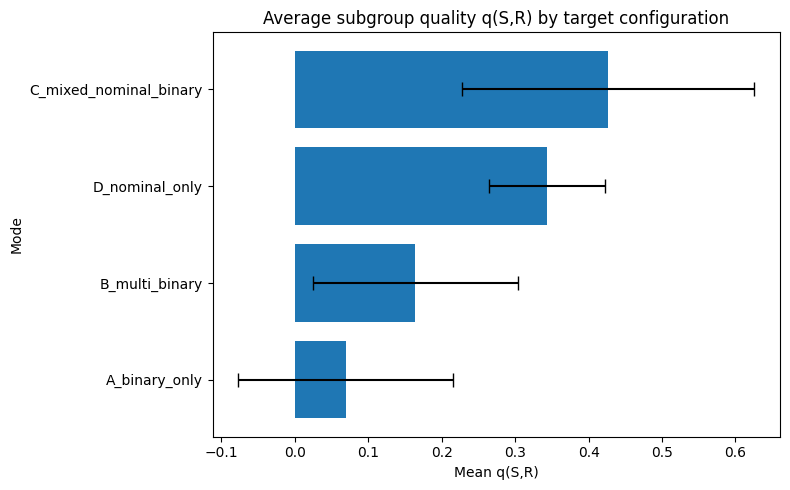

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
summary_sorted = summary.sort_values("mean_q", ascending=True)
plt.barh(summary_sorted["mode"], summary_sorted["mean_q"], xerr=summary_sorted["std_q"], capsize=5)
plt.xlabel("Mean q(S,R)")
plt.ylabel("Mode")
plt.title("Average subgroup quality q(S,R) by target configuration")
plt.tight_layout()
plt.show()


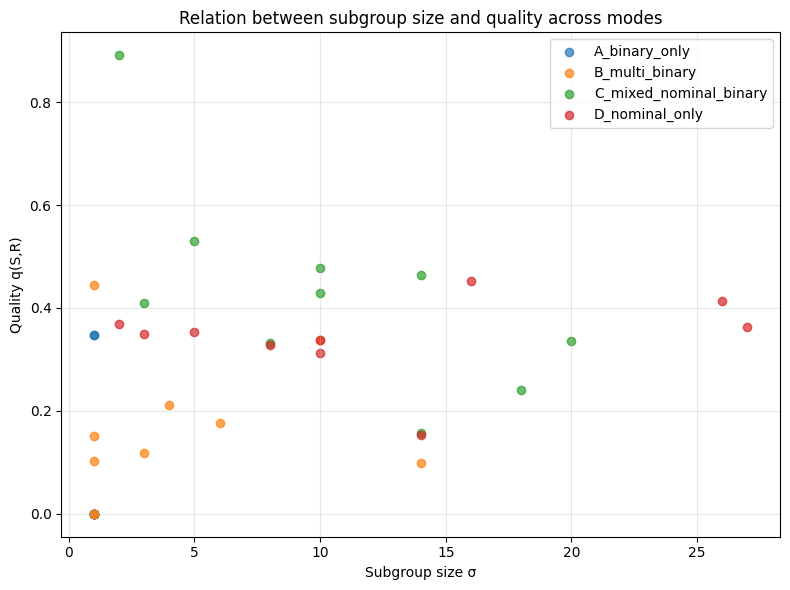

In [ ]:
plt.figure(figsize=(8,6))
for mode, group in results.groupby("mode"):
    plt.scatter(group["sigma"], group["q"], label=mode, alpha=0.7)

plt.xlabel("Subgroup size σ")
plt.ylabel("Quality q(S,R)")
plt.title("Relation between subgroup size and quality across modes")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


<Figure size 1500x600 with 0 Axes>

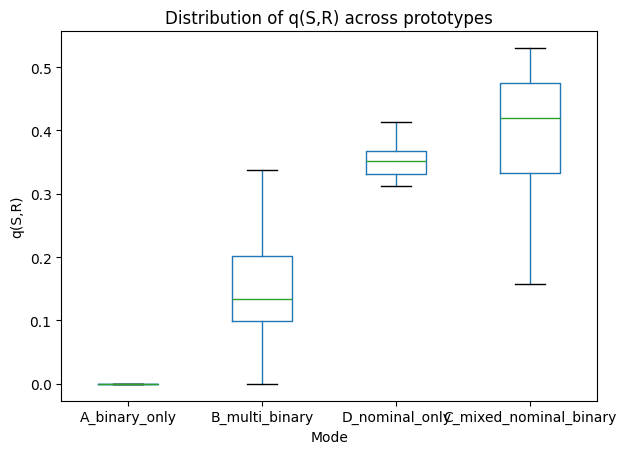

In [ ]:
plt.figure(figsize=(15,6))
modes_order = ["A_binary_only", "B_multi_binary", "D_nominal_only", "C_mixed_nominal_binary"]
results["mode"] = pd.Categorical(results["mode"], categories=modes_order, ordered=True)
results.boxplot(column="q", by="mode", grid=False, showfliers=False)
plt.suptitle("")
plt.title("Distribution of q(S,R) across prototypes")
plt.xlabel("Mode")
plt.ylabel("q(S,R)")
plt.tight_layout()
plt.show()


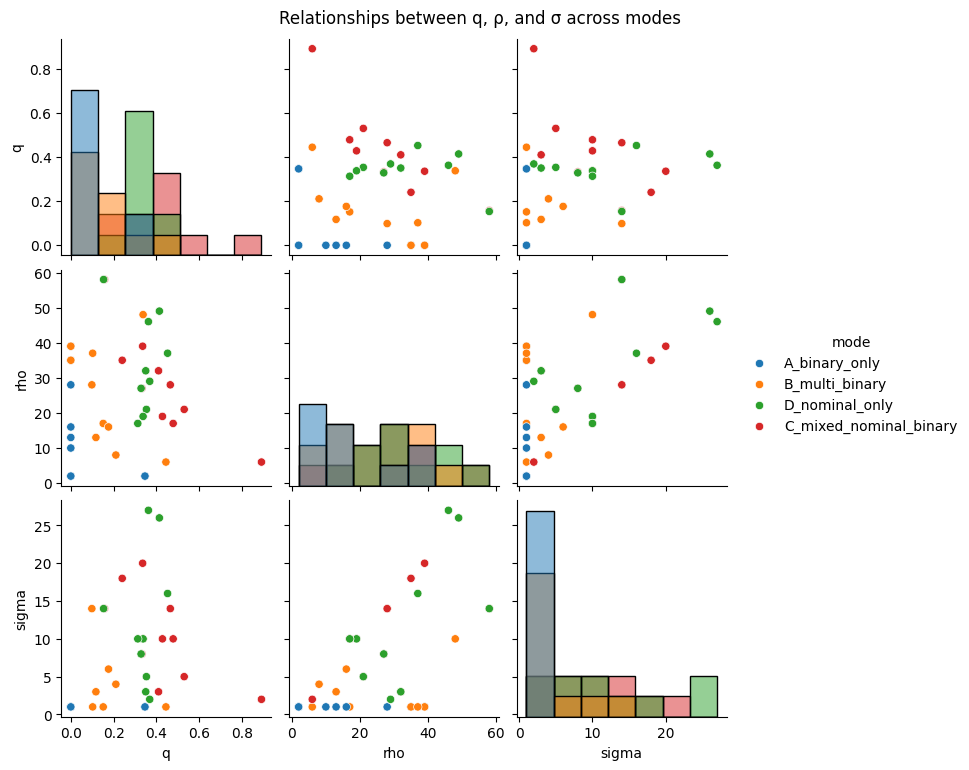

In [ ]:
import seaborn as sns

sns.pairplot(results, vars=["q","rho","sigma"], hue="mode", diag_kind="hist")
plt.suptitle("Relationships between q, ρ, and σ across modes", y=1.02)
plt.show()


In [ ]:
from tqdm import tqdm

all_vertices = list(G.nodes())
print(f"[INFO] Evaluating all {len(all_vertices)} vertices as prototypes.")

records = []

for proto in tqdm(all_vertices, desc="Evaluating prototypes"):
    for mode_name, cfg in MODES.items():
        res = find_best_q_for_prototype(
            G,
            proto,
            binary_attrs=cfg["binary"],
            nominal_attrs=cfg["nominal"]
        )
        if res is None:
            continue
        rec = {
            "mode": mode_name,
            "prototype": res["prototype"],
            "q": res["q"],
            "rho": res["rho"],
            "sigma": res["sigma"],
            "n_out_edges": res["n_out_edges"],
            "n_binary_targets": len(cfg["binary"]),
            "n_nominal_targets": len(cfg["nominal"]),
        }
        records.append(rec)

# Convert results to DataFrame
results = pd.DataFrame.from_records(records)
if results.empty:
    raise RuntimeError("No results produced — check that graph has outgoing edges.")

per_proto_summary = results.groupby(["prototype", "mode"]).agg(
    q_mean=("q", "mean"),
    q_max=("q", "max"),
    rho_mean=("rho", "mean"),
    sigma_mean=("sigma", "mean"),
    n_out_edges=("n_out_edges", "max")
).reset_index()

print("\n=== Per-prototype results (first 20 rows) ===")
print(per_proto_summary.head(20).to_string(index=False))

summary = results.groupby("mode").agg(
    prototypes_evaluated=("prototype", "nunique"),
    mean_q=("q", "mean"),
    std_q=("q", "std"),
    median_q=("q", "median"),
    mean_rho=("rho", "mean"),
    mean_sigma=("sigma", "mean"),
    mean_out_edges=("n_out_edges", "mean"),
    n_binary_targets=("n_binary_targets", "max"),
    n_nominal_targets=("n_nominal_targets", "max"),
).reset_index().sort_values("mean_q", ascending=False)

print("\n=== Overall summary ===")
print(summary.to_string(index=False))


[INFO] Evaluating all 225 vertices as prototypes.


Evaluating prototypes: 100%|██████████| 225/225 [00:01<00:00, 175.76it/s]


=== Per-prototype results (first 20 rows) ===
 prototype                   mode   q_mean    q_max  rho_mean  sigma_mean  n_out_edges
         4          A_binary_only 0.346574 0.346574       2.0         1.0           94
         4         B_multi_binary 0.444538 0.444538       6.0         1.0           94
         4 C_mixed_nominal_binary 0.891146 0.891146       6.0         2.0           94
         4         D_nominal_only 0.368848 0.368848      29.0         2.0           94
         8          A_binary_only 0.346574 0.346574       2.0         1.0          104
         8         B_multi_binary 0.102186 0.102186      37.0         1.0          104
         8 C_mixed_nominal_binary 0.410063 0.410063      32.0         3.0          104
         8         D_nominal_only 0.350219 0.350219      32.0         3.0          104
        12          A_binary_only 0.000000 0.000000      18.0         1.0           98
        12         B_multi_binary 0.164159 0.164159      18.0         6.0          